## **1. Tải bộ dữ liệu**

In [1]:
# Tải bộ thư viện datasets.
!pip install datasets==2.13.1

In [2]:
# Tải bộ dữ liệu MS MACRO.
from datasets import load_dataset

dataset = load_dataset('ms_marco', 'v1.1', ignore_verifications=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1760: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


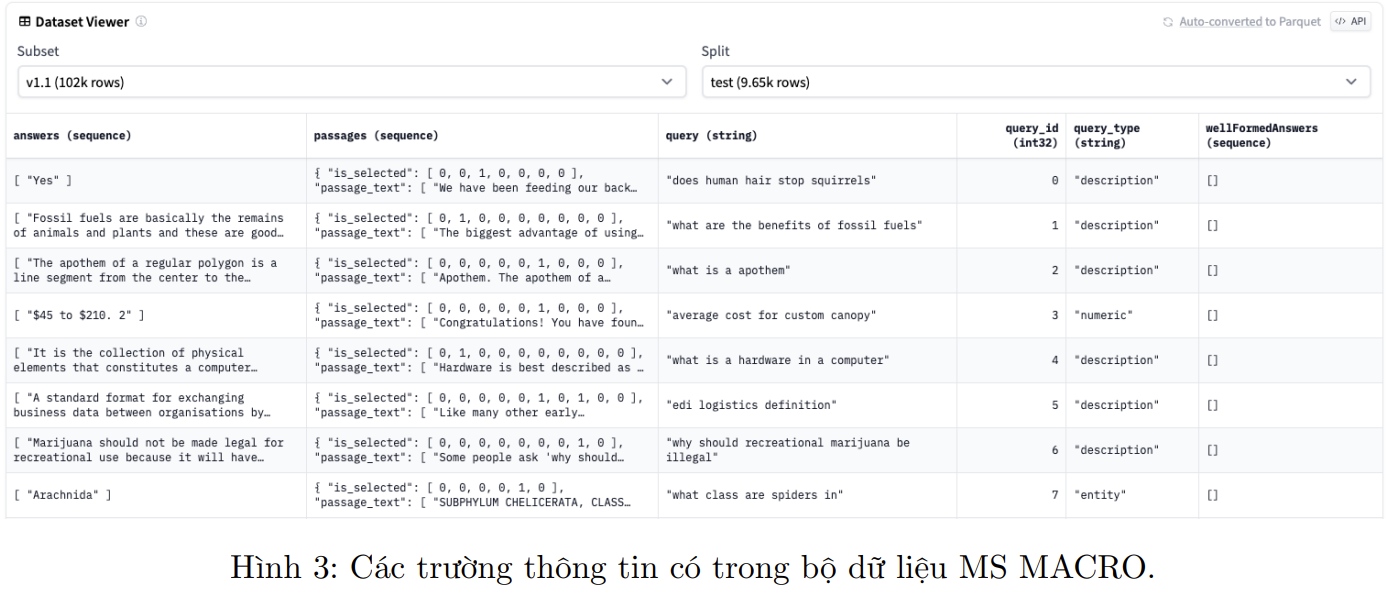

Trong phạm vi của project ta sẽ quan tâm đến hai cột chính:

*  "**query (string)**": Cột chứa mô tả câu truy vấn.

*  "**passages (squence)**": Cột chứa các tài liệu có nội dung tương đồng câu truy vấn. Trong đó, tài liệu được gán *is_selected = 1* là nhãn của tài liệu có liên quan đến câu truy vấn (theo ngữ cảnh của bộ dữ liệu hỏi-đáp thì tài liệu này sẽ chứa câu trả lời cho câu hỏi (câu truy vấn)).

In [3]:
!python3 -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **2. Xây dựng danh sách câu truy vấn và tài liệu**

Vì bộ dữ liệu lớn nên ta sẽ thực thiện trên tập **test** của bộ dữ liệu, đồng thời chỉ chọn các câu truy vấn *query_type = "entity"*.

In [4]:
# Chọn bộ test.
subset = dataset['test']
print(subset)

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 110742
})


In [5]:
# khai báo danh sách chứa tập câu truy vấn và tài liệu có liên quan.
queries_infos = []
queries = []
corpus = []

In [6]:
# Thực hành việc tách dữ liệu.

# Duyệt qua từng sample trong bộ test và chỉ chọn các sample có câu truy vấn thuộc kiểu "entity".
for sample in subset:
  query_type = sample['query_type']
  if query_type != 'entity':
    continue

  # Lấy nội dung của câu truy vấn và id của chúng (có thể bỏ id để giảm bộ nhớ).
  query_id = sample['query_id']
  query_str = sample['query']

  # Lấy danh sách các tài liệu và nhãn tương ứng của câu truy vấn.
  passages_dict = sample['passages']
  is_selected_lst = passages_dict['is_selected']
  passage_text_lst = passages_dict['passage_text']

  # Khai báo dict chứa thông tin cho câu truy vấn.
  query_info = {
      'query_id': query_id,
      'query': query_str,
      'relevant_docs': []
  }

  # Từ danh sách các tài liệu và nhãn, ta chọn các tài liệu được gán có liên quan đến câu truy vấn và đưa vào key "relevant_docs".
  # Ta lưu trữ nhãn dưới dạng chỉ mục list corpus.
  current_len_corpus = len(corpus)
  for idx in range(len(is_selected_lst)):
    if is_selected_lst[idx] == 1:
      doc_idx = current_len_corpus + idx
      query_info['relevant_docs'].append(doc_idx)

  # Bỏ qua các sample không chứa tài liệu có liên cho câu truy vấn để thuận tiện trong việc đánh giá.
  if query_info['relevant_docs'] == []:
    continue

  # Đưa thông tin câu truy vấn và tài liệu vào các danh sách đã khai báo ở bước 2.
  queries.append(query_str)
  queries_infos.append(query_info)
  corpus += passage_text_lst

## **3. Xây dựng hàm chuẩn hóa văn bản**

Việc chuẩn hóa văn bản giúp ta giảm được độ phức tập trong việc biểu diễn văn bản. Trong project này, ta xây dựng một hàm **text_normalize()** với tham số đầu vào là một chuỗi **s**, sau đó trả về một chuỗi đã được chuẩn hóa. Các kỹ thuật ta dùng trong project này bao gồm:

*  **Chuyển chữ viết thường (Lowercasing)**
*  **Xóa dấu câu (Punctuations Removal)**
*  **Xóa stopwords (Stopwords Removal)**
*  **Stemming**

In [7]:
# Import module string trong python.
import string
# Import thư viện nltk và import 2 module về stopwords và stemming của thư viện này.
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tokenize

# Tải bộ stopwords của tiến Anh về và khai báo thành list.
nltk.download('stopwords')
englist_stopwords = stopwords.words('english')

# Khai báo danh sách các dấu câu cần xóa (danh sách này dướ dạng string).
remove_chars = string.punctuation

# Khai báo một thực thể PorterStemmer, dùng để gọi hàm stemming về sau.
stemmer = PorterStemmer()

# Khai báo hàm text_normalize() với tham số đầu vào là một string.
def text_normalize(text):
  # Thực hành kỹ thuật chuyển chữ viết thường.
  text = text.lower()

  # Thực hành kỹ thuật xóa dấu câu.
  for char in remove_chars:
    text = text.replace(char, '')

  # Thực hiên kỹ thuật xóa stopwords.
  text = ' '.join([word for word in nltk.word_tokenize(text) if word not in englist_stopwords])

  # Thực hiện kỹ thuật stemming.
  text = ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)])

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **4. Xây dựng bộ từ vựng (dictionary)**

Từ bộ ngữ liệu cho trước, ta thực hiện chuẩn hóa văn bản và sử dụng kỹ thuật Tokenization để tách thành các token. Với mỗi token nhận được, kiểm tra nếu token hiện tại không tồn tại trong bộ từ vựng thì ta sẽ thêm nó vào.

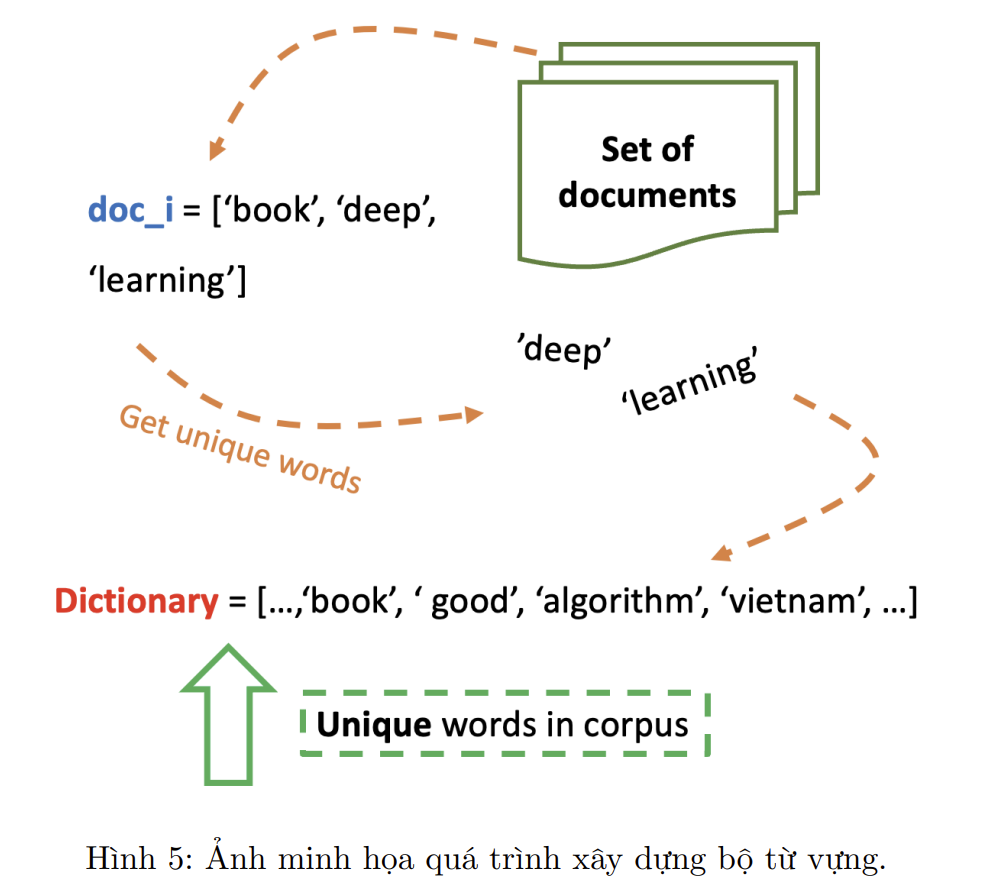

In [8]:
# Khai báo hàm create_dictionary() nhận đầu vào là danh sách cá tài liệu (string).
def create_dictionary(corpus):
  # Khai báo một list rỗng, dùng để chứa các từ vựng về sau.
  dictionary = []

  # Duyệt qua các tài liệu trong corpus và thực hiện chuẩn hóa chúng.
  for doc in corpus:
    normalize_doc = text_normalize(doc)
    # Thực hiện tách token các tài liệu đã được chuẩn hóa.
    tokens = nltk.word_tokenize(normalize_doc)

    # Duyệt qua từng token đã tách, nếu token nào chưa có trong bộ từ vựng thì thêm vào.
    for token in tokens:
      if token not in dictionary:
        dictionary.append(token)

  # Trả về list dictionary đã khai báo ở dòng 2.
  return dictionary

## **5. Xây dựng hàm vector hóa văn bản**

Vì máy tính không thể tính toán chuỗi văn bản nên ta biểu diễn văn bản dưới dạng vector. Trong project này ta xây dựng hàm **vectorize()** với tham số đầu vào là một chuỗi văn bản **s** và bộ từ vựng **vocab**, sau đó thực hiện vector hóa văn bản sử dụng kỹ thuật bag-of-words dựa trên bộ từ vựng cho trước, kết quả trả về sẽ là vector bag-of-words của văn bản đầu vào.                                                                                                                                                                                             

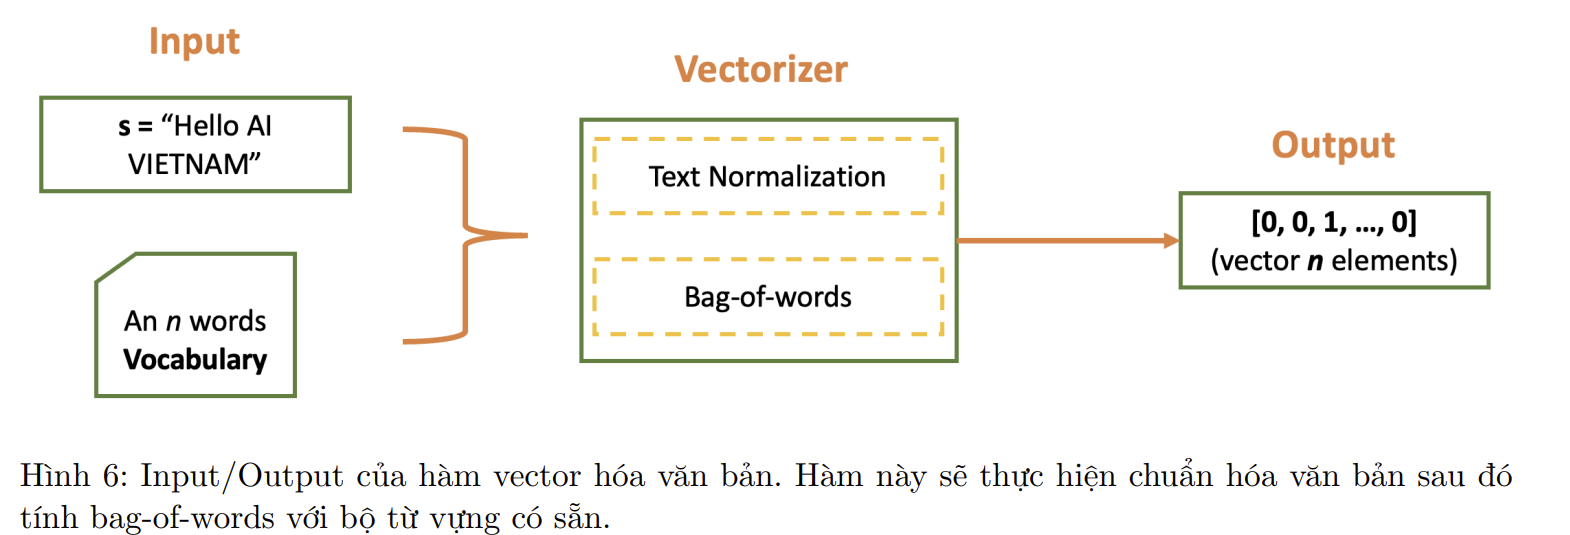

In [9]:
# Khai báo hàm vectorize() nhận tham số đầu vào là một văn bản kiểu string và một bộ từ vựng kiểu list.
def vectorize(text, dictionary):
  # Xây dựng một dictionary dùng để tạm thời khởi tạo giá trị 0 cho toàn bộ các từ vựng trong bộ từ vựng.
  word_count_dict = {word: 0 for word in dictionary}

  # Thực hiện tách token vă bản đầu vào.
  tokens = nltk.word_tokenize(text)

  # Duyệt qua danh sách token, nếu token có trong bộ từ vựng thì sẽ +1, nếu không sẽ bỏ qua.
  for token in tokens:
    try:
      word_count_dict[token] += 1
    except:
      pass

  # Lấy danh sách các value trong dictionary ở dòng 2 để làm vector đại diện cho văn bản đầu vào và trả về.
  vector = list(word_count_dict.values())
  return vector

## **6. Xây dựng ma trận document-term**

 Với các tài liệu trong bộ ngữ liệu, ta cần lưu trữ dạng
biểu diễn vector của chúng trong một cấu trúc được gọi là ma trận document-term. Trong ma
trận này, mỗi hàng sẽ đại diện cho một tài liệu và mỗi cột sẽ đại diện cho mỗi từ (term) trong bộ
từ vựng. Như vậy, giả sử với một bộ ngữ liệu gồm có ba tài liệu văn bản có nội dung như sau:
*  **doc1** = "Read AI book"
*  **doc2** = "Machine Learning book"
*  **doc3** = "Learning how AI learns"

Sau khi thực hiện chuẩn hóa văn bản và tokenization, ta thu thập các token độc nhất trong toàn
bộ bộ ngữ liệu để lập thành bộ từ vựng gồm [’read’, ’book’, ’ai’, ’machine’, ’learn’, ’how’]. Dựa
vào danh sách từ vựng có được, tính tần suất xuất hiện của mỗi từ trong bộ từ vựng với từng
văn bản đã được tokenize để từ đó có được dạng vector biểu diễn của chúng. Trong ma trận
document-term, ba vector này chính là 3 hàng của ma trận tượng trưng cho 3 tài liệu và các giá
trị trong vector sẽ tượng trưng cho các cột đại diện cho các từ trong bộ từ vựng.

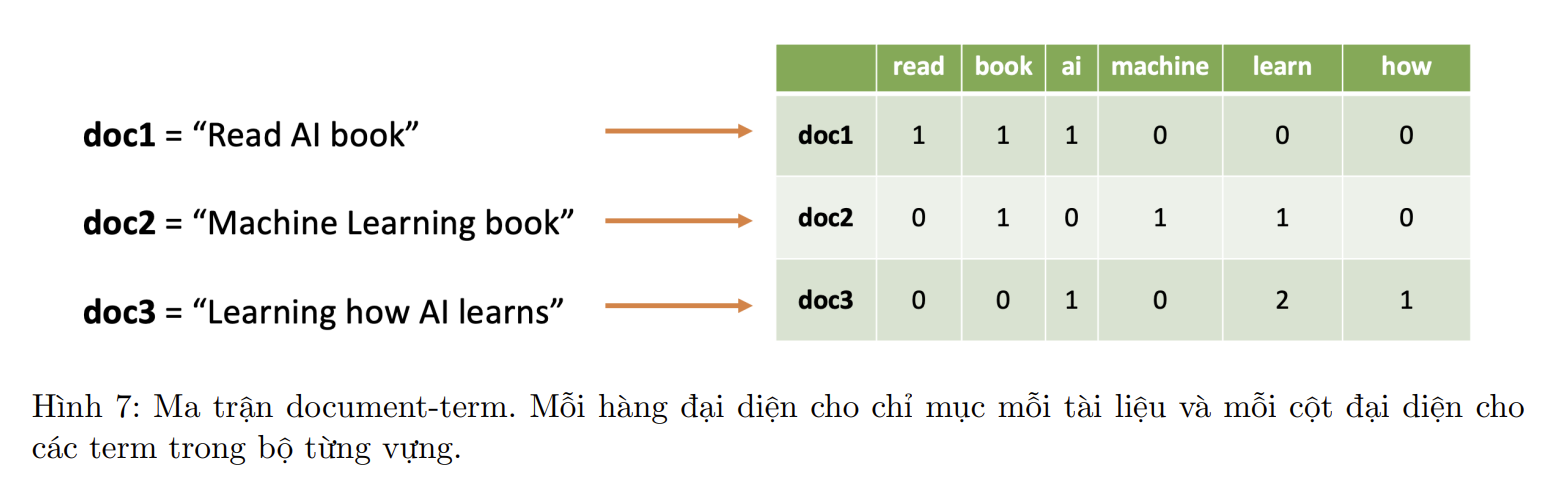

In [10]:
# Khai báo hàm create_doc_term_matrix() nhận tham số đầu vào là list các tài liệu và list các từ vựng.
def create_doc_term_matrix(corpus, dictionary):
  # Khai báo một dict rỗng dùng để làm ma trận doc-term.
  doc_term_matrix = {}

  # Duyệt qua từng tài liệu trong bộ ngữ liệu, thực hiện vector hóa văn bản
  # và thêm vào ma trận doc-term. Để demo được rõ ràng, ta đưa cả nội dung tài liệu vào phần key.
  # Chỉ mục của tài liệu cũng được đưa vào để thuận tiện trong việc đánh giá.
  for idx, doc in enumerate(corpus):
    normalize_doc = text_normalize(doc)
    vector = vectorize(normalize_doc, dictionary)
    doc_term_matrix[(doc, idx)] = vector

  #  Trả về ma trận doc-term.
  return doc_term_matrix

## **7. Xây dựng hàm tính độ tương đồng giữa hai vector**

Để có thể tìm được các tài liệu có liên quan đến câu truy vấn, ta có thể sử dụng các công thức được dùng để đo sự tương đồng giữa hai vector (ở đây sẽ hiểu là vector tài liệu và vector câu truy vấn), từ đó xây dựng một hàm similarity() nhận đầu vào là hai vector có cùng kích thước, sau đó trả về một giá trị là điểm đại diện cho độ tương đồng của vector này.


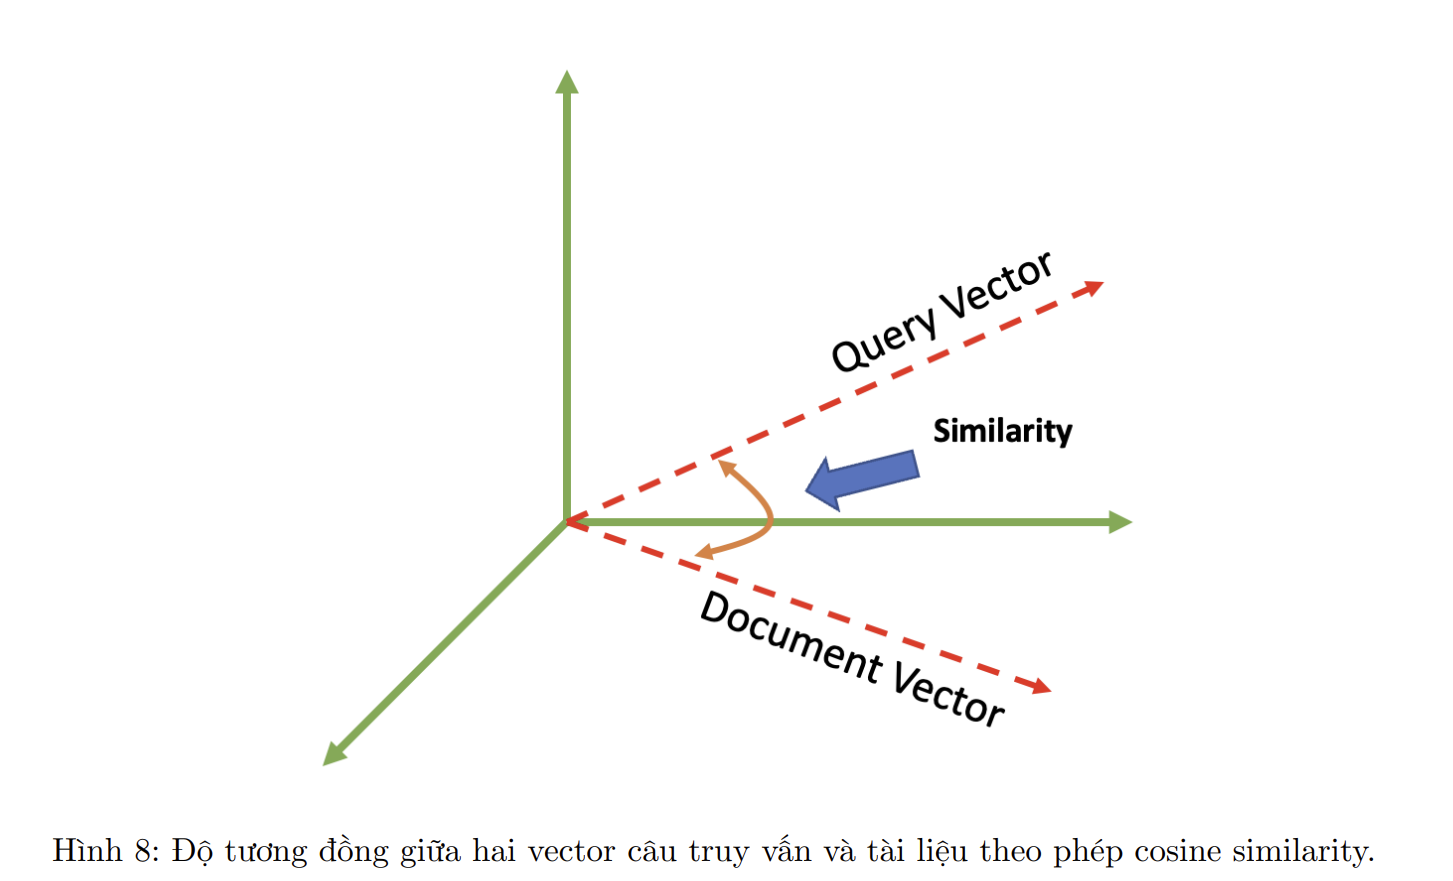

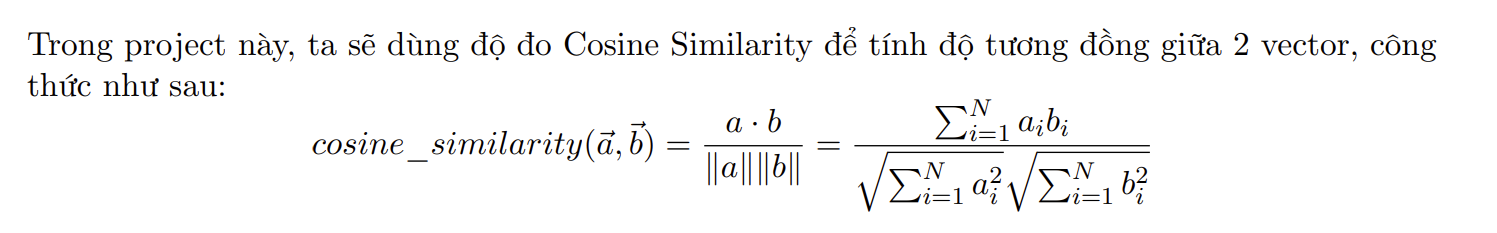

In [11]:
# Sử dụng thư viên scipy để triển khai cosine similarity.
from scipy import spatial

def similarity(a, b):
  return 1 - spatial.distance.cosine(a, b)

## **8. Xây dựng hàm truy vấn**

dựa trên các thành phần đã xây dựng ở các bước trên, ta sẽ bắt đầu thực hiện tìm kiếm các tài liệu có liên quan đến một chuỗi văn bản câu truy vấn cho
trước, các bước thực hiện như sau:

(a) **Vector hóa câu truy vấn:** Với một chuỗi văn bản truy vấn cho trước, sử dụng hàm
vectorize() đã khai báo trước đó để tìm được dạng biểu vector của câu truy vấn. Giả sử,
với câu truy vấn có nội dung q = "Machine Learning", khi đưa vào vectorize(), chuỗi
câu truy vấn sẽ được chuẩn hóa và tính vector bag-of-words trên bộ vocab đã tìm được trước
đó, cuối cùng sẽ được kết quả là {’read’: 0, ’book’: 0, ’ai’: 0, ’machine’: 1, ’learn’: 1, ’how’:
0} hay [0, 0, 0, 1, 1, 0].

(b) **Tính độ tương đồng:** Với từng tài liệu trong ma trận document-term, thực hiện tính độ
tương đồng giữa vector câu truy vấn với vector tài liệu (có thể lưu kết quả này vào một list).

(c) **Thực hiện xếp hạng:** Sau khi có danh sách các điểm tương đồng, thực hiện sắp xếp theo
thứ tự giảm dần về điểm tương đồng. Cuối cùng, các tài liệu nằm ở đầu danh sách đã sắp
xếp này sẽ có thể được coi là có liên quan nhất đến câu truy vấn.


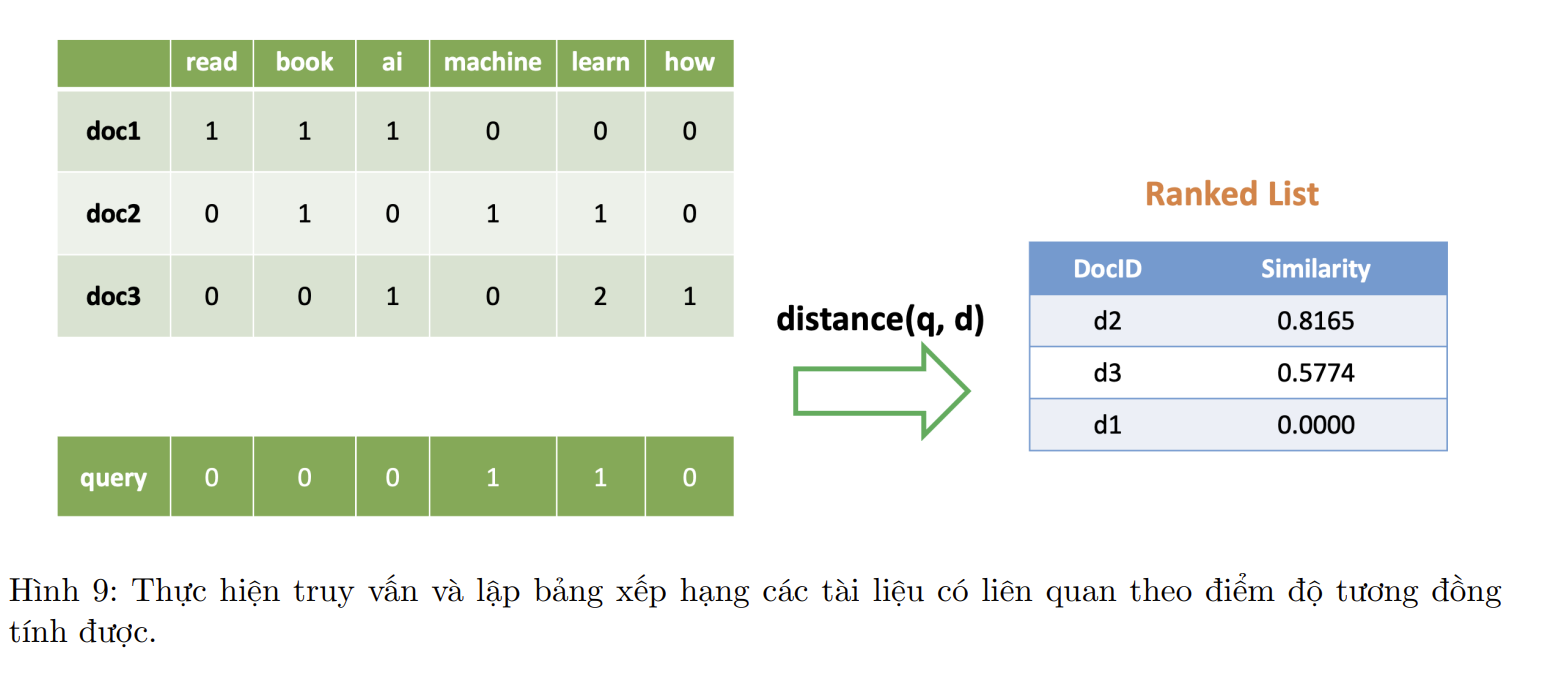

In [12]:
# Khai báo hàm ranking() nhận tham số đầu vào là câu truy vấn, bộ từ vựng và ma trận doc term.
def ranking(query, dictionary, doc_term_matrix):
  # Thực hiện vector hóa văn bản.
  normalized_query = text_normalize(query)
  query_vec = vectorize(normalized_query, dictionary)

  # Khởi tạo danh sách dùng để chứa kết quả cosine similarity.
  scores = []

  # Duyệt qua từng tài liệu trong ma trận doc-term, thực hiện tính cosine similarity
  # giữa vector câu truy vấn và vector tài liệu đang xét. Sau đó, đưa kết quả này vào danh sách scores.
  for doc_info, doc_vec in doc_term_matrix.items():
    sim = similarity(query_vec, doc_vec)
    scores.append((sim, doc_info))

  #  Sắp xếp kết quả cosine similarity theo thứ tự giảm dần. Từ đây ta tìm được ranked list.
  scores.sort(reverse=True)

  # Trả về ranked list.
  return scores

## **9. Thực hiện truy vấn bất kì**

In [13]:
query_lst = ['what is the official language in Fiji']
top_k = 10
dictionary = create_dictionary(corpus)
doc_term_matrix = create_doc_term_matrix(corpus, dictionary)
for query in query_lst:
  scores = ranking(query, dictionary, doc_term_matrix)
  print(f'Query: {query}')
  print('=== Relevant docs ===')
  for idx in range(top_k):
    doc_score = scores[idx][0]
    doc_content = scores[idx][1][0]

    print(f'Top {idx + 1}; Score: {doc_score:.4f}')
    print(doc_content)
    print('\n')

Query: what is the official language in Fiji
=== Relevant docs ===
Top 1; Score: 0.6556
The official languages in Fiji are Fijian and English. A dialect of Hindustani is also widely spoken among Indo-Fijians.  _________________________________________   T … he official and everyday language of Fiji is English. Fijian and Fiji-Hindi are second languages in the island nation.


Top 2; Score: 0.6556
The official languages in Fiji are Fijian and English. A dialect of Hindustani is also widely spoken among Indo-Fijians.  _________________________________________   T … he official and everyday language of Fiji is English. Fijian and Fiji-Hindi are second languages in the island nation.


Top 3; Score: 0.6468
The official languages. Fiji’s 1997 Constitution established Fijian as one of the official languages of the country. Fijian is an Austronesian language, a grouping that includes thousands of other languages spanning the globe. The language is of the Malayo-Polynesian family, not too diff